## Data Understanding

### YELP Open Dataset


#### Builiding an initial database with json files

There are several json files on data set from Yelp( https://www.yelp.com/dataset ),
upload to mongodb with

> mongoimport

And build some indexs on the mongodb collections with

> db.collection.createIndex

Dataset has Business, Reviews, Pictures for 10 Metropolitan areas.

#### Import necessary libraries

In [1]:
import pymongo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
plt.style.use('bmh')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline

#### Setup for accessing database

In [2]:
mc = pymongo.MongoClient()
db = mc['yelp']

In [3]:
business_coll = db['business']
review_coll = db['review']

#### Shapes of Data

Business Collection

In [4]:
# how many business?
business_coll.count_documents({})

192609

In [5]:
# what's inside?
cur = business_coll.find({})
next(cur)

{'_id': ObjectId('5ced65b1ba8666cdc2af7fa8'),
 'business_id': 'xvX2CttrVhyG2z1dFg_0xw',
 'name': 'Farmers Insurance - Paul Lorenz',
 'address': '15655 W Roosevelt St, Ste 237',
 'city': 'Goodyear',
 'state': 'AZ',
 'postal_code': '85338',
 'latitude': 33.4556129678,
 'longitude': -112.3955963552,
 'stars': 5.0,
 'review_count': 3,
 'is_open': 1,
 'attributes': None,
 'categories': 'Insurance, Financial Services',
 'hours': {'Monday': '8:0-17:0',
  'Tuesday': '8:0-17:0',
  'Wednesday': '8:0-17:0',
  'Thursday': '8:0-17:0',
  'Friday': '8:0-17:0'}}

In [6]:
# how many states?
states = business_coll.find({}).distinct("state")
print(states)

['AZ', 'ON', 'NC', 'AB', 'NV', 'OH', 'PA', 'QC', 'WI', 'IL', 'NY', 'SC', 'TX', 'UT', 'NM', 'FL', 'CA', 'VA', 'BAS', 'NE', 'AK', 'XGM', 'WA', 'XWY', 'CON', 'BC', 'GA', 'VT', 'CT', 'AL', 'DUR', 'TN', 'NJ', 'AR', 'XGL', 'DOW']


In [7]:
# how many cities?
cities = business_coll.find({}).distinct("city")
len(cities)

1204

A lot of Cities in the dataset,

we choose Las Vegas because there are many visitors

In [8]:
# how many businesses in Las Vegas?
business_coll.count_documents({'city':'Las Vegas'})

29370

In [9]:
# how many restaurants in Vegas?
business_coll.count_documents({'categories':{"$regex": u"Restaurants"}, 
                               'city':'Las Vegas'})

6450

In [10]:
# Get restaurants in vegas to Data Frame
vegas_cur = business_coll.find({'categories':{"$regex": u"Restaurants"}, 
                               'city':'Las Vegas'})
vegas_df = pd.DataFrame(list(vegas_cur))

In [11]:
vegas_df.head()

,_id,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,5ced65b1ba8666cdc2af7fc0,6055 E Lake Mead Blvd,"{'BikeParking': 'True', 'BusinessParking': '{'...",tstimHoMcYbkSC4eBA1wEg,"Mexican, Restaurants, Patisserie/Cake Shop, Fo...",Las Vegas,"{'Monday': '11:0-21:0', 'Tuesday': '10:0-21:0'...",1,36.195615,-115.040529,Maria's Mexican Restaurant & Bakery,89156,184,4.5,NV
1,5ced65b1ba8666cdc2af7fc5,"1775 E Tropicana Ave, Ste 29","{'OutdoorSeating': 'False', 'BusinessAcceptsCr...",PZ-LZzSlhSe9utkQYU8pFg,"Restaurants, Italian",Las Vegas,None,0,36.100016,-115.128529,Carluccio's Tivoli Gardens,89119,40,4.0,NV
2,5ced65b1ba8666cdc2af7ff2,6125 Spring Mountain Rd,"{'RestaurantsPriceRange2': '1', 'Ambience': '{...",kANF0dbeoW34s2vwh6Umfw,"Fast Food, Food, Restaurants, Ice Cream & Froz...",Las Vegas,None,0,36.125031,-115.225620,Dairy Queen,89146,33,2.0,NV
3,5ced65b1ba8666cdc2af8015,4343 N Rancho Dr,None,X8mtoSxY8whtmbDlj0D3Aw,"Restaurants, Chinese",Las Vegas,None,1,36.238596,-115.233331,Imperial Asian Buffet,89030,4,2.0,NV
4,5ced65b1ba8666cdc2af8033,"Artisan Hotel, 1501 W Sahara Ave","{'RestaurantsAttire': ''dressy'', 'Corkage': '...",bJP4l_BGq2CudEu0m-wNjg,"Restaurants, Pizza, Italian, American (New)",Las Vegas,"{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",0,36.143672,-115.169792,Artisan Fine Dining Room,89102,3,2.0,NV


In [12]:
# Draw Heatmap with review_count for business
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import branca.colormap as cm

s = vegas_df.loc[:, ['latitude', 'longitude', 'review_count']]
data=s.loc[:, ['latitude', 'longitude', 'review_count']]

map = folium.Map(location=[vegas_df['latitude'].median(),
                           vegas_df['longitude'].median()], 
                 zoom_start=9,
                 width=800, height=800)

heat_df = data[['latitude', 'longitude', 'review_count']]

# List comprehension to make out list of lists
heat_data = [[row['latitude'],row['longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
plugins.HeatMap(heat_data, radius=8).add_to(map)
map.fit_bounds(map.get_bounds())

map

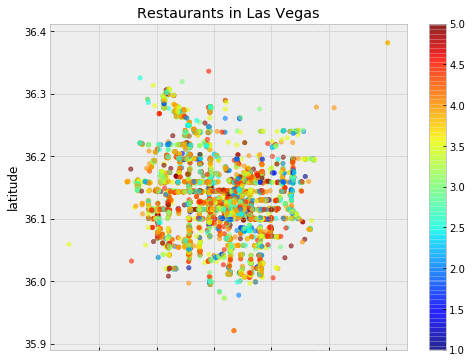

In [13]:
# how stars are spread on the map
_ = vegas_df.plot(kind='scatter', 
                  x='longitude', 
                  y='latitude',
                  c=vegas_df['stars'], 
                  cmap=plt.get_cmap('jet'), 
                  colorbar=True,
                  alpha=0.6,
                  title='Restaurants in Las Vegas',
                  figsize=(8, 6))

Review Collection

In [14]:
# how many reviews?
review_coll.count_documents({})

6685900

In [15]:
# what's inside?
cur = review_coll.find({})
next(cur)

{'_id': ObjectId('5ced66f9ba8666cdc2b7f848'),
 'review_id': '2TzJjDVDEuAW6MR5Vuc1ug',
 'user_id': 'n6-Gk65cPZL6Uz8qRm3NYw',
 'business_id': 'WTqjgwHlXbSFevF32_DJVw',
 'stars': 5.0,
 'useful': 3,
 'funny': 0,
 'cool': 0,
 'text': "I have to say that this office really has it together, they are so organized and friendly!  Dr. J. Phillipp is a great dentist, very friendly and professional.  The dental assistants that helped in my procedure were amazing, Jewel and Bailey helped me to feel comfortable!  I don't have dental insurance, but they have this insurance through their office you can purchase for $80 something a year and this gave me 25% off all of my dental work, plus they helped me get signed up for care credit which I knew nothing about before this visit!  I highly recommend this office for the nice synergy the whole office has!",
 'date': '2016-11-09 20:09:03'}

#### Let's check the stars on reviews

In [16]:
# Get all stars in reviews
cursor = review_coll.find({})

stars = [review['stars'] for review in cursor]
len(stars)

6685900

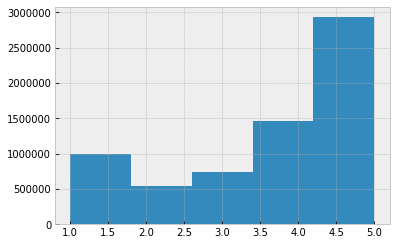

In [17]:
# Historam of stars for all reviews
plt.hist(stars, bins=5);

#### What is differ stars on business and review

In [18]:
# Check with Restaurants in Vegas
# Get stars on Business and
# Get stars of average on Reviews for the Business
cur = business_coll.find({'categories':{"$regex": u"Restaurants"}, 
                          'city':'Las Vegas'})

print('Business', '   Ave of reviews')
print('---------------------------')
for i, doc in enumerate(cur):
    review_cur = review_coll.find({
        'business_id': doc['business_id']
    })
    stars = 0
    counts = 0
    for review in review_cur:
        stars += review['stars']
        counts += 1
        
    print(doc['stars'], '       ', stars/counts)
    
    # for only 10 business
    if i == 10:
        break

Business    Ave of reviews
---------------------------
4.5         4.301587301587301
4.0         4.097560975609756
2.0         2.242424242424242
2.0         1.75
2.0         2.0
3.0         2.9661016949152543
3.5         3.6482504604051567
4.5         4.666666666666667
4.5         4.666666666666667
3.5         3.6785714285714284
4.0         4.012820512820513


#### Make an review_dataframe for Trainging/Testing Classifier

In [19]:
# get_reviews function
def get_reviews(category = u'Restaurants', 
                city='Las Vegas', 
                max_business_count = 1000):    
    '''Return reviews list for category/city'''

    cursor = business_coll.find({'categories': {"$regex": category},  
                                 'city':city})

    review_list = []
    count = 0
    for doc in cursor:
        review_cur = review_coll.find({
            'business_id': doc['business_id']
        })

        # Do it for only max_count
        count +=1
        if count == max_business_count:
            break

        # Just extract stars and text from review
        for review in review_cur:
            data = {}
            data['stars'] = review['stars']
            data['text'] = review['text']
            review_list.append(data)

    return review_list

#### Build Data Set for Training Classifier

Start with review for 1000 business

In [20]:
review_df = pd.DataFrame(get_reviews())

In [21]:
review_df.head()

,stars,text
0,4.0,We found out about this gem from The Man's co-...
1,3.0,"The ""chips"" are a fried corn tortilla which we..."
2,4.0,The pollo mole is well worth the trip out here...
3,3.0,I've ordered Caldo de Rez from here twice and ...
4,5.0,My boyfriend doesn't like Mexican food yet he ...


#### Write some functions to check performance of model

In [22]:
def get_accuracy(labels, predicts):
    '''Return probability of accuray'''
    count = 0
    total = 0

    for i, value in enumerate(labels):
        if value == predicts[i]:
            count += 1
        total = i+1

    return count / total

In [23]:
def check_model(pipeline, dataframe, test_size=0.2, random_state=42):
    '''Return performance of pipeline with dataframe'''
    # set train & test variables
    X_train, X_test, y_train, y_test = train_test_split(dataframe['text'], 
                                                        dataframe['target'], 
                                                        test_size=test_size, 
                                                        random_state=random_state)
    
    # fit to model
    pipeline.fit(X_train, y_train)
    
    # predict with test data
    test_pred_val = pipeline.predict(X_test)
    test_pred_prob = pipeline.predict_proba(X_test)

    # predict with train data
    train_pred_val = pipeline.predict(X_train)
    train_pred_prob = pipeline.predict_proba(X_train)

    # calculate performance of model
    test_accuracy = get_accuracy(y_test, test_pred_val)
    test_logloss = log_loss(y_test, test_pred_prob)
    
    train_accuracy = get_accuracy(y_train, train_pred_val)
    train_logloss = log_loss(y_train, train_pred_prob)

    # return result
    return ({
        'test_accuracy': test_accuracy,
        'test_logloss': test_logloss,
        'train_accuracy': train_accuracy,
        'train_logloss': train_logloss
    })
    

In [24]:
# Parameters for TF-IDF vectorize
ngrams_1 = {
    'ngram_range': (1, 1),
    'stop_words': 'english',
    'dtype': 'int32',
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': 'word',
    'min_df': 2
}

Base model with TFIDF-Logistic Regression

In [25]:
pp_1n_logi = Pipeline([
    ('tfidf', TfidfVectorizer(ngrams_1)),
    ('classifier', LogisticRegression(solver='liblinear',
                                      multi_class='ovr'))
])

In [26]:
review_df['target'] = review_df['stars']

In [27]:
# test model with check_model function
first_test = check_model(pp_1n_logi, review_df)


In [28]:
first_test

{'test_accuracy': 0.6495568090249798,
 'test_logloss': 0.8448144293305668,
 'train_accuracy': 0.7058582575645658,
 'train_logloss': 0.7572538215738449}

### Change target to 3 categories

First model is not bad, but need to be improved.<br>
There are a lot more 4, 5 stars than 1, 2, 3 stars, <br>
Set 1, 2, 3 stars to 'Bad', 4 stars to 'Neutral', 5 stars to 'Good'

In [29]:
# set new "class" column 
review_df['target'] = 'Bad'
review_df.loc[review_df['stars'] == 5, 'target'] = 'Good'
review_df.loc[review_df['stars'] == 4, 'target'] = 'Neutral'

In [30]:
# array for histogram
hist_data = []
for target in review_df['target']:
    if target == 'Good':
        hist_data.append(3)
        continue
    if target == 'Neutral':
        hist_data.append(2)
        continue
    if target == 'Bad':
        hist_data.append(1)

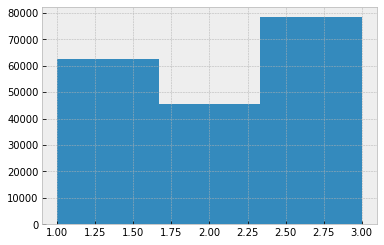

In [31]:
# Draw histogram for Bad/Neutral/Good
plt.hist(hist_data, bins=3);

In [32]:
# another check with model
category3_test = check_model(pp_1n_logi, review_df)

In [33]:
# show result
category3_test

{'test_accuracy': 0.7536932581251679,
 'test_logloss': 0.5823332556792181,
 'train_accuracy': 0.787070736915618,
 'train_logloss': 0.528981976414413}

Test with 2-ngrams

In [34]:
ngrams_2 = {
    'ngram_range': (2, 2),
    'stop_words': 'english',
    'dtype': 'int32',
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': 'word',
    'min_df': 2
}

In [35]:
pp_2n_logi = Pipeline([
    ('tfidf', TfidfVectorizer(ngrams_2)),
    ('classifier', LogisticRegression(solver='liblinear',
                                      multi_class='ovr'))
])

In [36]:
twongrams_test = check_model(pp_2n_logi, review_df)

In [37]:
twongrams_test

{'test_accuracy': 0.7536932581251679,
 'test_logloss': 0.5823332556792181,
 'train_accuracy': 0.787070736915618,
 'train_logloss': 0.528981976414413}

#### with MORE reviews

In [38]:
more_review = pd.DataFrame(get_reviews(category='Restaurants', city='Las Vegas', max_business_count = 4000 ))

In [39]:
more_review['target'] = 'Bad'
more_review.loc[more_review['stars'] == 5, 'target'] = 'Good'
more_review.loc[more_review['stars'] == 4, 'target'] = 'Neutral'

In [40]:
more_data_test = check_model(pp_1n_logi, more_review)

In [41]:
more_data_test

{'test_accuracy': 0.756166426935166,
 'test_logloss': 0.5671105196776742,
 'train_accuracy': 0.7771555096808563,
 'train_logloss': 0.5363666393326931}

#### Export model with Pickle

In [42]:
import pickle

In [43]:
with open('cust_voice_model.pkl', 'wb') as f:
    pickle.dump(pp_1n_logi, f) 

#### With SelectKBest

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [45]:
TOP_K = 20000

In [46]:
pp_KBest = Pipeline([
    ('tfidf', TfidfVectorizer(ngrams_2)),
    ('KBest', SelectKBest(f_classif, k=TOP_K)),
    ('classifier', LogisticRegression(solver='liblinear',
                                      multi_class='ovr'))
])

In [49]:
kbest20k_test = check_model(pp_KBest, more_review)

In [50]:
kbest20k_test

{'test_accuracy': 0.7564594321027116,
 'test_logloss': 0.5673810179242142,
 'train_accuracy': 0.7705761899212547,
 'train_logloss': 0.5464490849144116}

In [51]:
TOP_K = 2000

In [52]:
pp_2KBest = Pipeline([
    ('tfidf', TfidfVectorizer(ngrams_2)),
    ('KBest', SelectKBest(f_classif, k=TOP_K)),
    ('classifier', LogisticRegression(solver='liblinear',
                                      multi_class='ovr'))
])

In [53]:
kbest2k_test = check_model(pp_2KBest, more_review)

In [ ]:
kbest2k_test

#### With XGBOOST MODEL

In [ ]:
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [ ]:
pp_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngrams_1)),
    ('classifier', xgb.XGBClassifier())
])

In [ ]:
xgb_test = check_model(pp_clf, review_df)

In [ ]:
xgb_test

#### With SVM

In [ ]:
from sklearn import svm

In [ ]:
pp_svm = Pipeline([
    ('tfidf', TfidfVectorizer(ngrams_1)),
    ('classifier', svm.SVC(kernel='linear'))
])

In [ ]:
svm_test = check_model(pp_svm, review_df)

In [ ]:
svm_test